<a href="https://www.kaggle.com/code/samithsachidanandan/deep-cnn-image-classifier?scriptVersionId=270534014" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Import the Libraries 

In [1]:
import tensorflow as tf
import os

2025-10-24 12:47:52.996064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761310073.265912      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761310073.335624      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2025-10-24 12:48:10.946334: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
os.listdir('/kaggle/input/happy-and-sad-image/data')

['sad', 'happy']

### Remove dodgy images

In [5]:
import cv2
import imghdr
import warnings 
warnings.filterwarnings('ignore')

/tmp/ipykernel_13/1294757527.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [6]:
data_dir = '/kaggle/input/happy-and-sad-image/data' 

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

### Load Data

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:

data = tf.keras.utils.image_dataset_from_directory('/kaggle/input/happy-and-sad-image/data')

Found 171 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
batch = data_iterator.next()

In [13]:
categories = ['Happy', 'Sad']

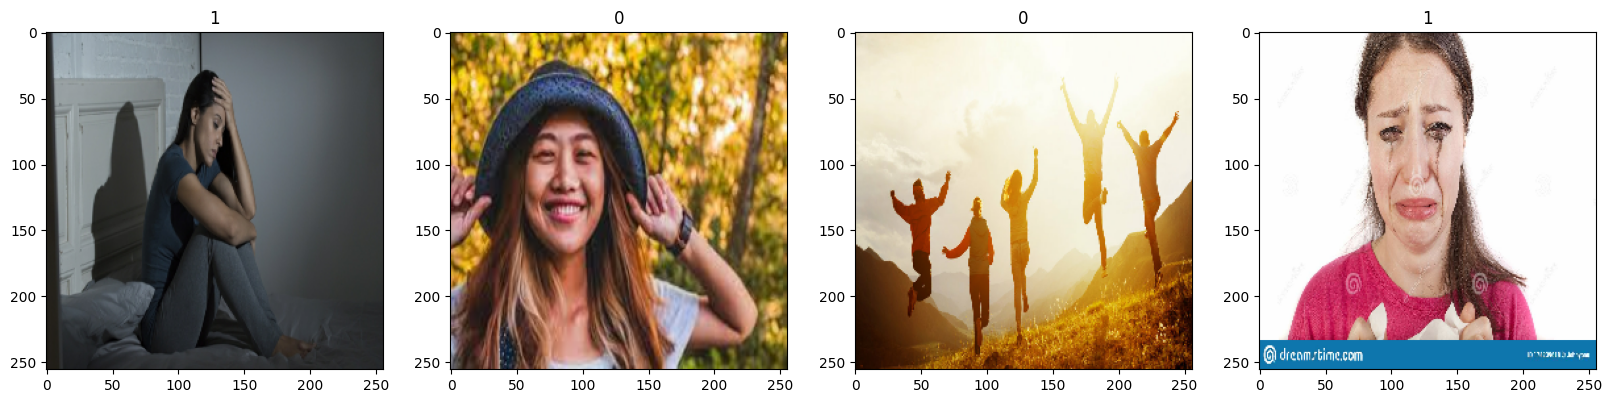

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Scale Data

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843]],
 
         [[0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843]],
 
         [[0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843]],
 
         ...,
 
         [[0.05490196, 0.4627451 , 0.6784314 ],
          [0.05490

###  Split Data

In [17]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=4)
    return image, label

In [18]:
data = data.map(one_hot_encode)

In [19]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [20]:
train_size

4

In [21]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

### Build Deep Learning Model

In [22]:

train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,GlobalAveragePooling2D

In [24]:
base = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(256,256,3))
base.trainable = False
model = tf.keras.Sequential([
    base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Train

In [27]:
logdir='logs'

In [28]:

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.3698 - loss: 1.4135 - val_accuracy: 1.0000 - val_loss: 0.2775
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8927 - loss: 0.3904 - val_accuracy: 0.9375 - val_loss: 0.2334
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9406 - loss: 0.2009 - val_accuracy: 0.9062 - val_loss: 0.2722
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9323 - loss: 0.1886 - val_accuracy: 1.0000 - val_loss: 0.0959
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9615 - loss: 0.1442 - val_accuracy: 1.0000 - val_loss: 0.0622
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9917 - loss: 0.0720 - val_accuracy: 1.0000 - val_loss: 0.0838
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9948 - loss: 0.0720 - val_accuracy: 1.0000 - val_loss: 0.0280
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9969 - loss: 0.0524 - val_accuracy: 1.0000 - val_loss: 0.0302
Epoch 9/20
4/4 

### Plot Performance

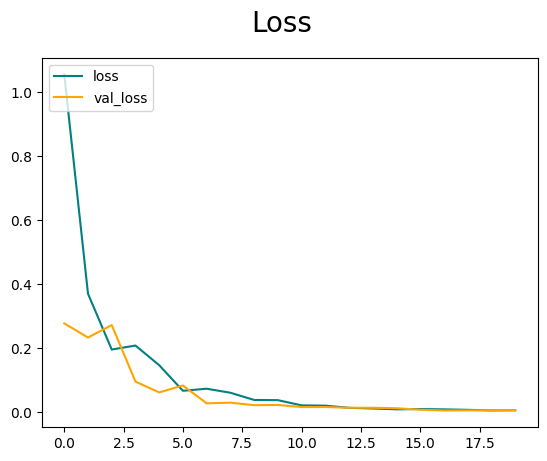

In [30]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

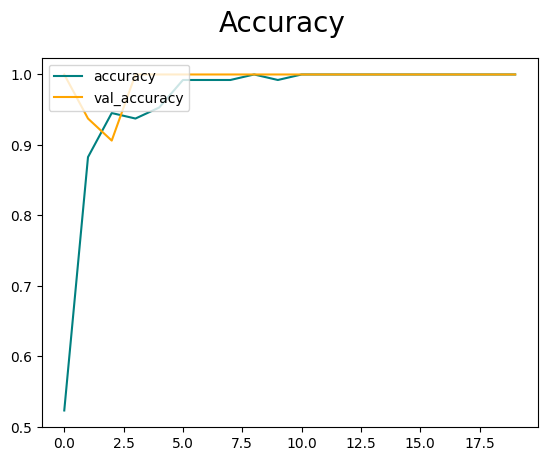

In [31]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

###  Evaluate

In [32]:

from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [33]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [34]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [35]:
print(f'Precision: {pre.result().numpy()}, Recall: { re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.0, Recall: 0.0, Accuracy: 0.0


### Test

In [36]:

import cv2

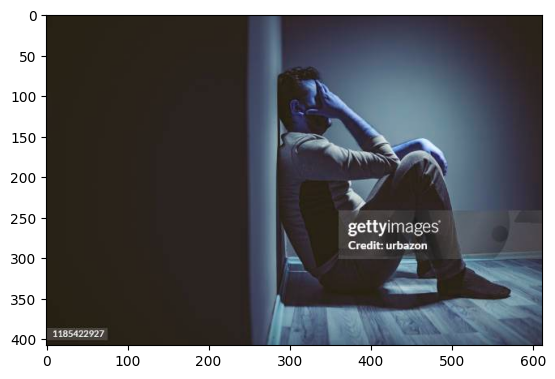

In [37]:
img = cv2.imread('/kaggle/input/happy-and-sad-image/sad.jpg')
plt.imshow(img)
plt.show()

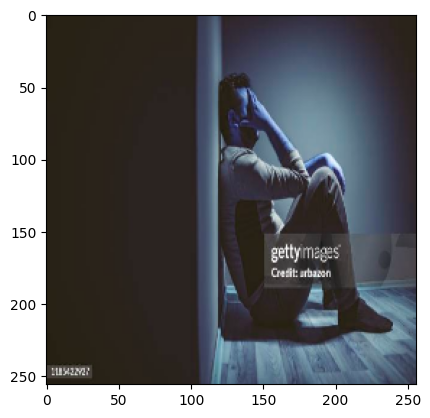

In [38]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [39]:

yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [40]:

predicted_class = np.argmax(yhat)

In [41]:
print(f'Predicted class is {categories[predicted_class]}')

Predicted class is Sad


### Save the Model

In [42]:
from tensorflow.keras.models import load_model

In [43]:
model.save('imageclassifier.keras')

In [44]:

new_model = load_model('imageclassifier.keras')

In [45]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[4.6426143e-02, 9.5357382e-01, 8.4107636e-09, 8.1900424e-11]],
      dtype=float32)